### 1. First we import all our libraries


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

In [3]:
import numpy as np

# Load the file
data = np.load(
    "face_images.npz",
    allow_pickle=True,
    encoding="latin1",
    mmap_mode="r",
    fix_imports=True,
)

imageWidth, imageHeight, numImgs = data["face_images"].shape
print(f"There are {numImgs} images with size {imageHeight} x {imageWidth}")

There are 7049 images with size 96 x 96


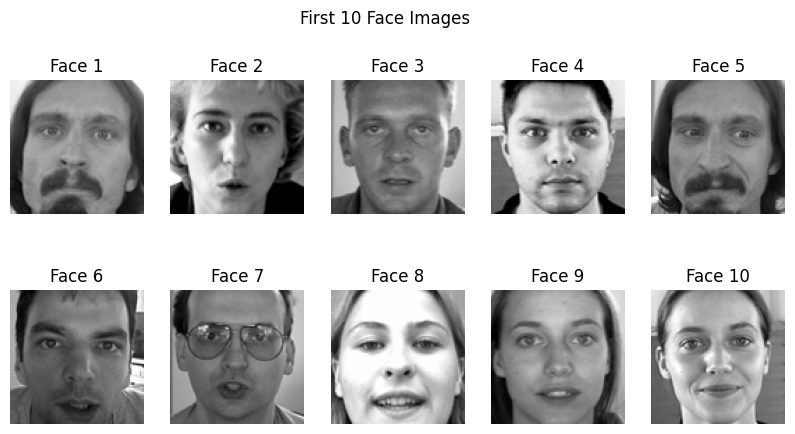

In [4]:
# Display first 10 images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(data["face_images"][:, :, i], cmap="gray")
    ax.set_title(f"Face {i+1}")
    ax.axis("off")
plt.suptitle("First 10 Face Images")
plt.show()

In [5]:
# Prepare data
X = data["face_images"].reshape(-1, numImgs)
X = X.T
X = X / 255.0  # Normalize

# Clean data
X = X[~np.isnan(X).any(axis=1)]

# Split data
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)

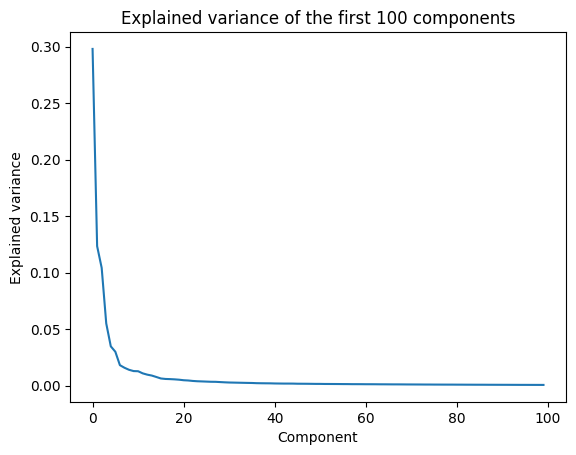

PCA(n_components=40, whiten=True)

In [6]:
pca = PCA()
pca.fit(X_train)

# Zoom in on the first 100 components
# Explained variance is the proportion of variance explained by each component
# The first component explains the most variance, the second component explains the second most, and so on
plt.plot(pca.explained_variance_ratio_[:100])
plt.xlabel("Component")
plt.ylabel("Explained variance")
plt.title("Explained variance of the first 100 components")
plt.show()
# We can see that around 40 components and more PCA components represent the same data.

n_components = 40
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

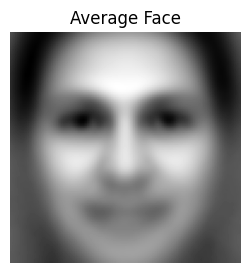

In [7]:
# Calculates mean face
# THIS IS OUR AVERAGE FACE FROM THE DATASET :O
mean_face = np.mean(data["face_images"], axis=2)
plt.figure(figsize=(3, 3))
plt.imshow(mean_face, cmap="gray")
plt.title("Average Face")
plt.axis("off")
plt.show()

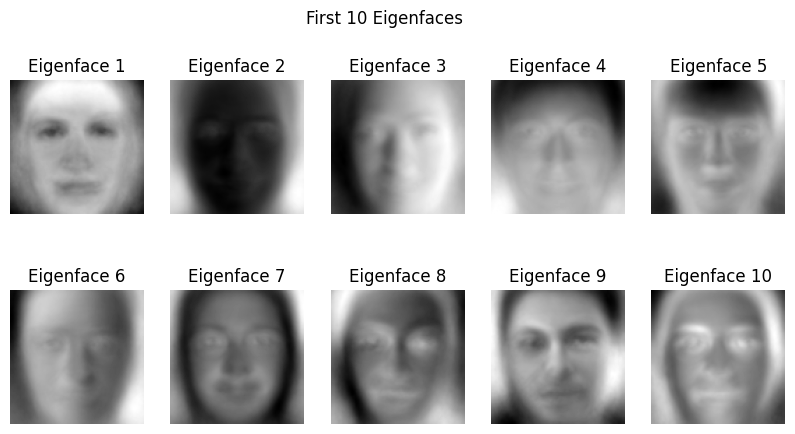

In [8]:
# Plotting the first 10 eigenfaces
# FEATURE EXTRACTION
# These are the most important components of the PCA
# Eigenfaces are the principal components of the dataset
# They are the directions in which the data varies the most
num_eigenfaces = len(pca.components_)
eigenfaces = pca.components_.reshape((num_eigenfaces, imageHeight, imageWidth))
eigenfaceTitles = [f"Eigenface {i+1}" for i in range(num_eigenfaces)]
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(eigenfaces[i], cmap="gray")
    ax.set_title(eigenfaceTitles[i])
    ax.axis("off")
plt.suptitle("First 10 Eigenfaces")
plt.show()

In [9]:
# Load pre-trained face detection model
faceCascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


# Detect faces and extract faces from the image
def detectAndExtractFaces(image):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Face detection
    faces = faceCascade.detectMultiScale(
        gray_image, scaleFactor=1.11, minNeighbors=5, minSize=(50, 50)
    )

    # Draw rectangles around detected faces
    for x, y, w, h in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Extract face regions
    faceRegions = []
    for x, y, w, h in faces:
        faceRegion = gray_image[y : y + h, x : x + w]
        faceRegionsResized = cv2.resize(faceRegion, (imageWidth, imageHeight))
        faceRegions.append(faceRegionsResized)

    cv2.imshow("Face Detection", image)
    cv2.waitKey(0)
    return np.array(faceRegions)

c:\Users\Zain\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


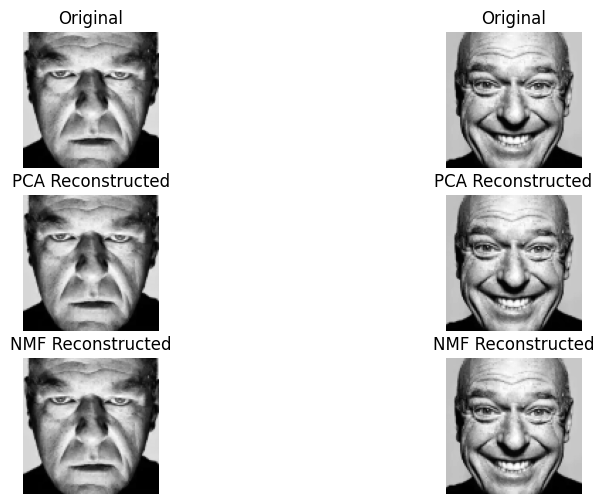

In [30]:
# PCA
pca = PCA(n_components=1, whiten=True)

# Images we want to detect and perform PCA and NMF on
imgs = ["SmileFrown.jpg"]  # ADD IMAGES HERE

for img in imgs:
    # Load images
    image = cv2.imread(img)

    # Bad image
    if image is None:
        print(f"Failed to load image: {img}")
        continue

    maxResizeAttempt = 5
    resizePer = 0.5
    for attempt in range(maxResizeAttempt):
        resized_image = cv2.resize(image, (0, 0), fx=resizePer, fy=resizePer)

        # Detect and extract faces
        faces = detectAndExtractFaces(resized_image)

        if len(faces) > 0:
            break

        resizePer += 0.1

    if len(faces) == 0:
        print(f"No faces detected in image: {img}")
        continue

    faceData = np.array(faces)

    # Normalize
    faceDataNormalized = faceData.astype(np.float32) / 255.0

    # Apply PCA
    pca = PCA(n_components=min(faceDataNormalized.shape))
    facePCA = pca.fit_transform(
        faceDataNormalized.reshape(-1, imageHeight * imageWidth)
    )

    # Apply NMF
    nmf = NMF(n_components=min(faceDataNormalized.shape), init="random", random_state=0)
    faceNMF = nmf.fit_transform(
        faceDataNormalized.reshape(-1, imageHeight * imageWidth)
    )

    # Reconstruct faces
    faceReconstructedPCA = pca.inverse_transform(facePCA)
    faceReconstructedNMF = nmf.inverse_transform(faceNMF)

    # Display original and reconstructed face images
    fig, axes = plt.subplots(nrows=3, ncols=len(faces), figsize=(10, 6))
    axes = axes.ravel()

    for i in range(len(faces)):
        axes[i].imshow(faces[i].reshape(imageHeight, imageWidth), cmap="gray")
        axes[i].set_title("Original")
        axes[i].axis("off")

        axes[len(faces) + i].imshow(
            faceReconstructedPCA[i].reshape(imageHeight, imageWidth), cmap="gray"
        )
        axes[len(faces) + i].set_title("PCA Reconstructed")
        axes[len(faces) + i].axis("off")

        axes[2 * len(faces) + i].imshow(
            faceReconstructedNMF[i].reshape(imageHeight, imageWidth), cmap="gray"
        )
        axes[2 * len(faces) + i].set_title("NMF Reconstructed")
        axes[2 * len(faces) + i].axis("off")

cv2.destroyAllWindows()